{100: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps100.log', 30: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps30.log', 40: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps40.log', 50: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps50.log', 60: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps60.log', 70: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps70.log', 80: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps80.log', 90: '/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/llama-7b_n1_mps90.log'}
{1: [30.4, 27.65, 21.348, 17.575, 17.205, 16.524, 16.444, 16.023], 2: [56.105, 48.396, 43.911, 28.842, 27.368, 25.102, 23.026, 23.19], 4: [111.535, 95.233, 74.748, 56.964, 53.902, 44.553, 42.268, 41.182], 8: [214.894, 162.745, 131.871, 111.005, 98.131, 88.026, 81.628, 78.332], 16: [396.907, 307.808, 251.067, 214.58,

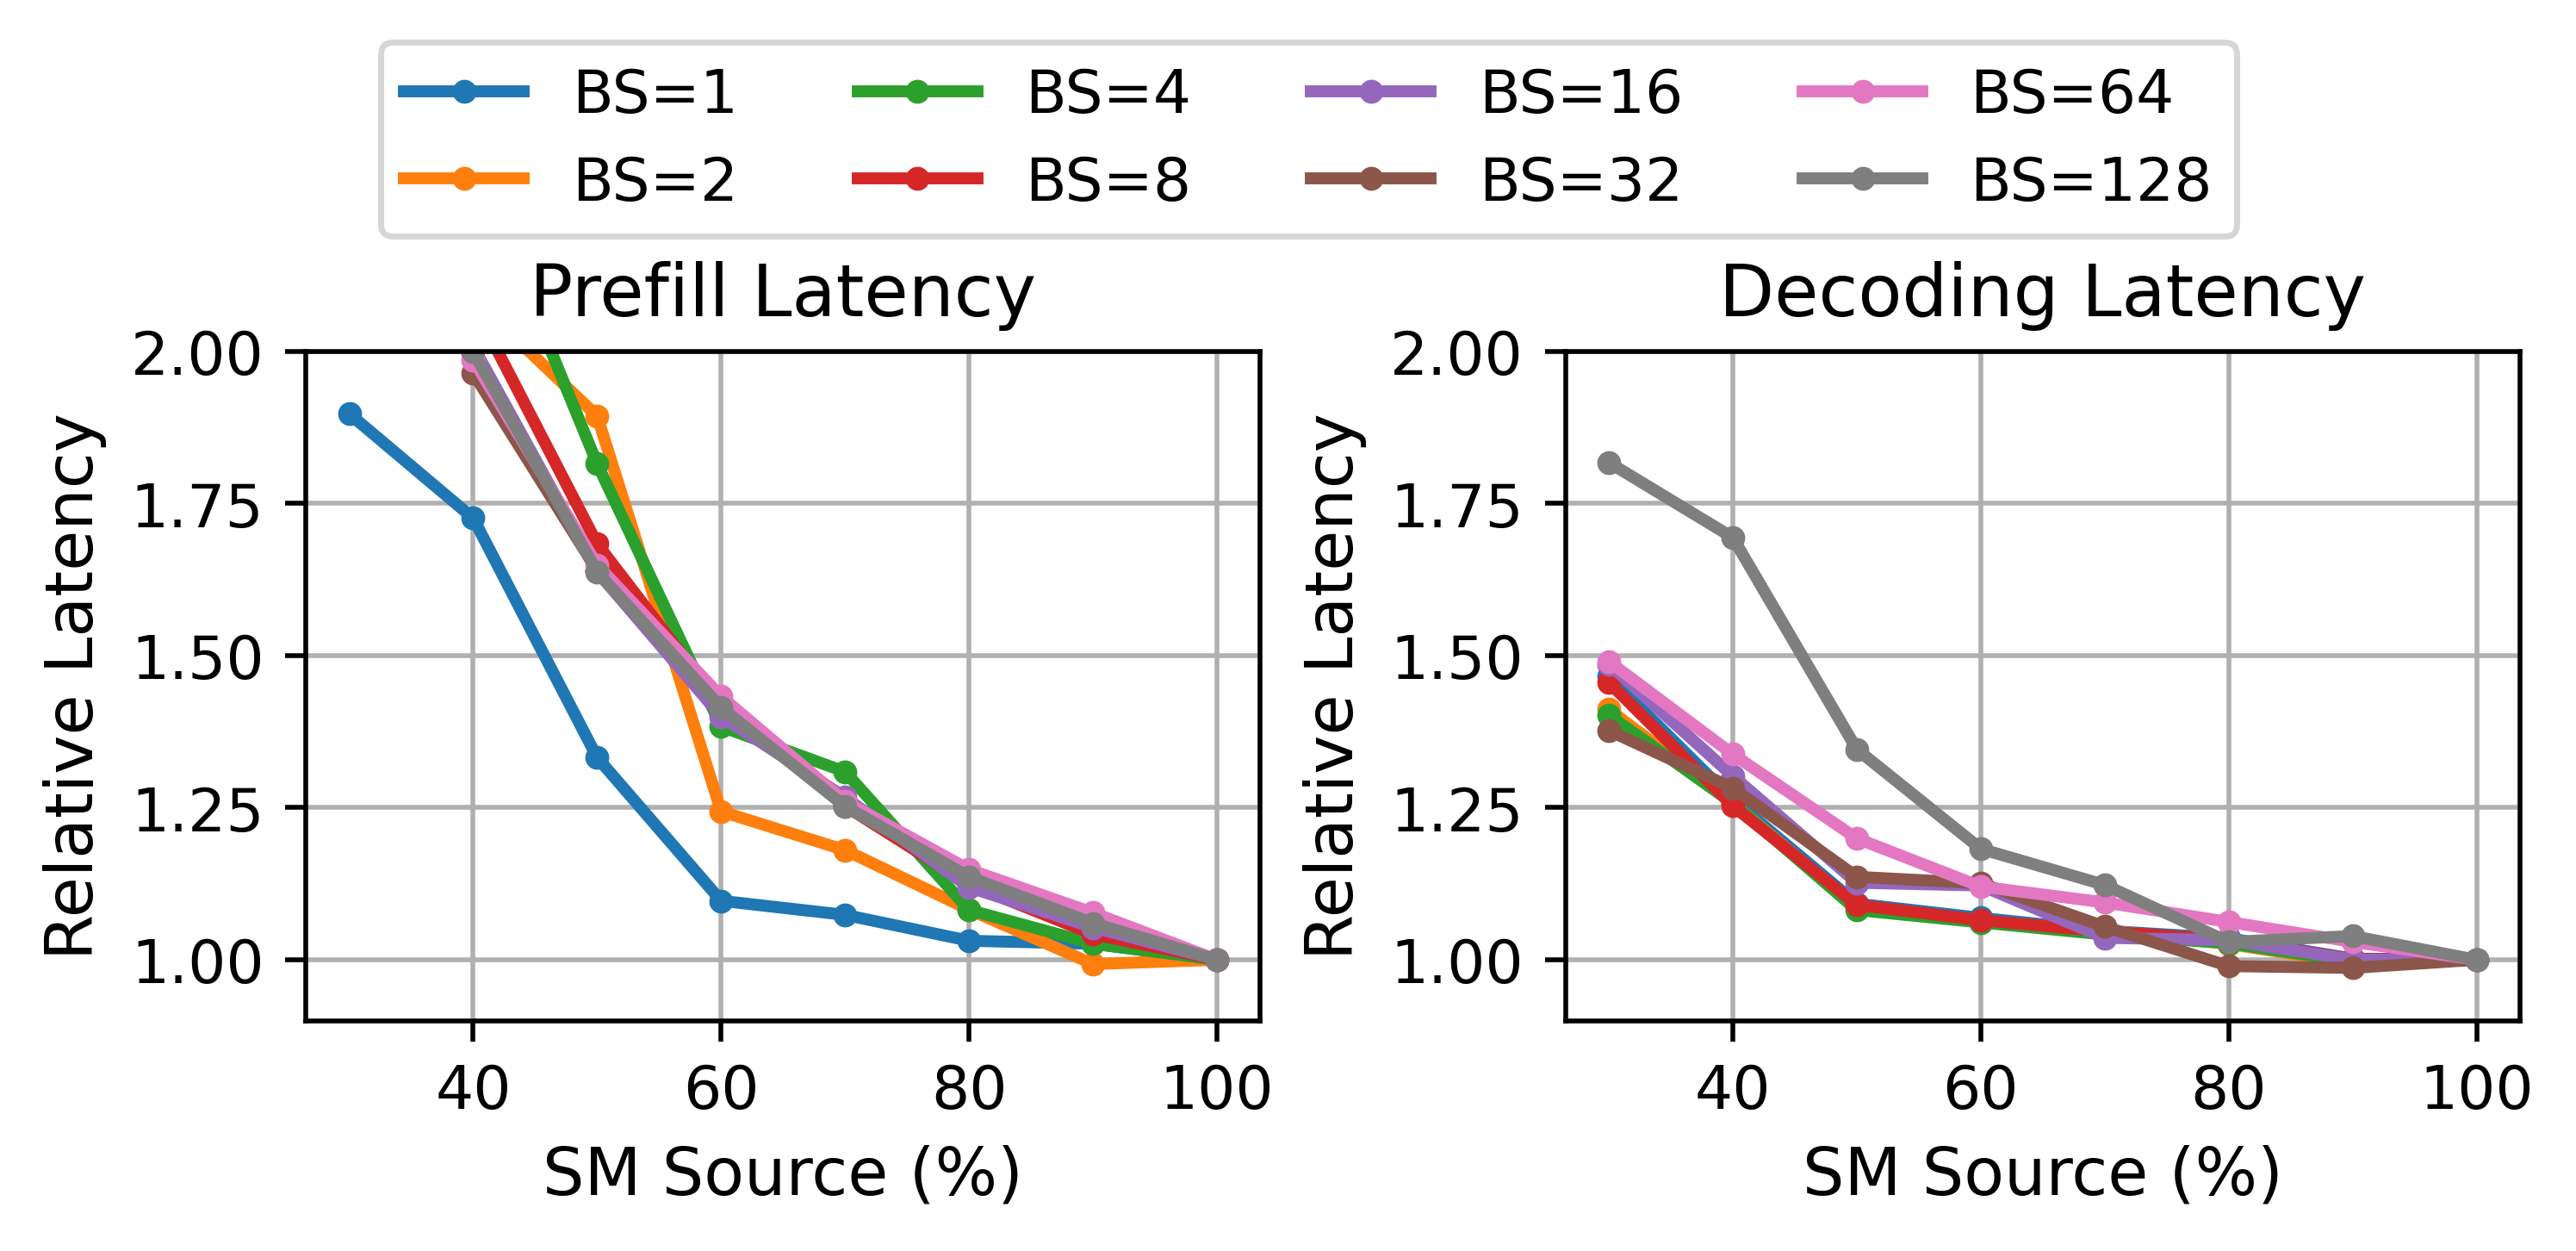

In [10]:
import os
import matplotlib.pyplot as plt

logdir = "/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism"
key_words = "llama-7b_n1"


def plot_sm(logfiles, seq_len=128):
    mps_list = []
    prefill_bs_lat, decoding_bs_lat = {}, {}
    for mps in sorted(logfiles):
        mps_list.append(mps)
        logfile = logfiles[mps]

        with open(logfile, "r") as f:
            find_result = False
            for line in f.readlines():
                if "BS, SL, Prefill Lat (ms), Decode Lat (ms)" in line:
                    find_result = True
                    continue
                if find_result:
                    split_line = line.strip().split(",")
                    if len(split_line) != 4:
                        break
                    batch_size = str(split_line[0].strip())
                    seq_len = str(split_line[1].strip())
                    if "N/A" in split_line[2]:
                        prefill_lat = 0
                    else:
                        prefill_lat = float(split_line[2].strip())
                    if "N/A" in split_line[3]:
                        decode_lat = 0
                    else:
                        decode_lat = float(split_line[3].strip())

                    if int(seq_len) == 128 and int(batch_size) < 256:
                        if int(batch_size) not in prefill_bs_lat:
                            prefill_bs_lat[int(batch_size)] = []
                        prefill_bs_lat[int(batch_size)].append(prefill_lat)
                        if int(batch_size) not in decoding_bs_lat:
                            decoding_bs_lat[int(batch_size)] = []
                        decoding_bs_lat[int(batch_size)].append(decode_lat)

    print(prefill_bs_lat)
    print(decoding_bs_lat)

    fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), dpi=500)
    for bs in sorted(prefill_bs_lat):
        relative_lat = [
            (lat / prefill_bs_lat[bs][-1]) for lat in prefill_bs_lat[bs]
        ]
        ax[0].plot(mps_list,
                   relative_lat,
                   label="BS={}".format(bs),
                   marker=".",
                   lw=2)
    ax[0].set_xlabel("SM Source (%)", fontsize=11)
    ax[0].set_ylabel("Relative Latency", fontsize=11)
    ax[0].set_ylim([0.9, 2.0])
    ax[0].grid()
    ax[0].set_title("Prefill Latency")

    for bs in sorted(decoding_bs_lat):
        relative_lat = [
            (lat / decoding_bs_lat[bs][-1]) for lat in decoding_bs_lat[bs]
        ]
        ax[1].plot(mps_list,
                   relative_lat,
                   label="BS={}".format(bs),
                   marker=".",
                   lw=2)
    ax[1].set_xlabel("SM Source (%)", fontsize=11)
    ax[1].set_ylabel("Relative Latency", fontsize=11)
    # ax[1].set_ylim([0.35, 1.05])
    ax[1].set_ylim([0.9, 2.0])
    ax[1].grid()
    ax[1].set_title("Decoding Latency")

    # merge legend and plot at the top
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.17))

    plt.tight_layout()
    fig.savefig(
        "/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_parallelism/{}_sm.pdf".
        format(key_words), bbox_inches='tight', pad_inches=0.02)
    plt.show()

logfiles = {}
for filename in os.listdir(logdir):
    if key_words in filename and "mps" in filename:
        if "old" in filename:
            continue
        mps = int(filename.split("_")[-1].split(".")[0][3:])
        logfiles[mps] = os.path.join(logdir, filename)

print(logfiles)
plot_sm(logfiles)


# Fairness

Model llm-0 (/mnt/afs/share/LLMCKPTs/huggyllama/llama-65b) group size 1280 blocks
Model llm-1 (/mnt/afs/share/LLMCKPTs/huggyllama/llama-30b) group size 780 blocks
Model llm-0 avg prompt len 778.25, avg output len 251.04
Model llm-1 avg prompt len 128.39, avg output len 126.39
Model llm-0 finished 78 requests, tpt 0.419 req/s
Model llm-1 finished 653 requests, tpt 3.504 req/s
[FCFS] Total throughput 3.923 req/s, Finish time 186.359 s, Weighted throughput 3.161 req/s
Model llm-0 finished 40 requests, tpt 0.348 req/s
Model llm-1 finished 628 requests, tpt 5.466 req/s
[Round-Robin] Total throughput 5.814 req/s, Finish time 114.886 s, Weighted throughput 4.898 req/s
Model llm-0 finished 11 requests, tpt 0.126 req/s
Model llm-1 finished 640 requests, tpt 7.354 req/s
[ADBS] Total throughput 7.481 req/s, Finish time 87.024 s, Weighted throughput 6.551 req/s


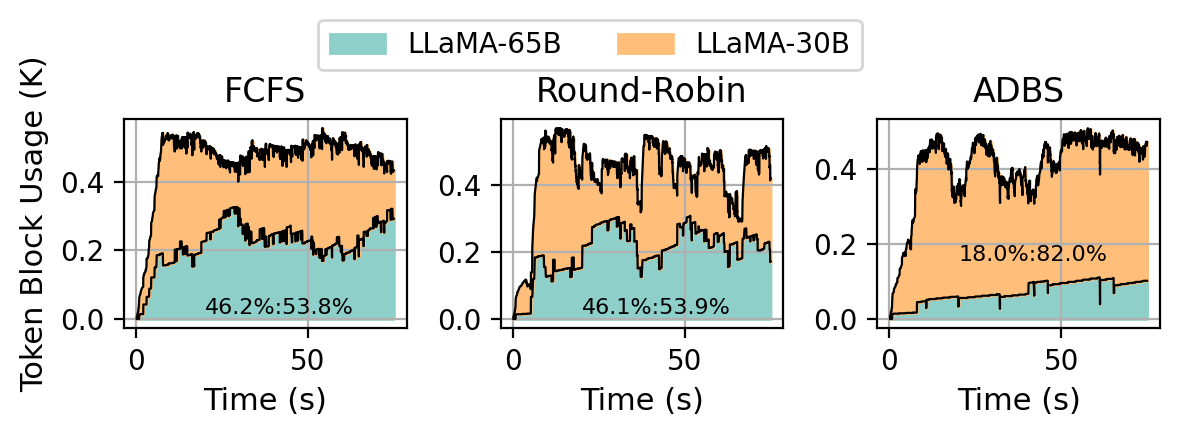

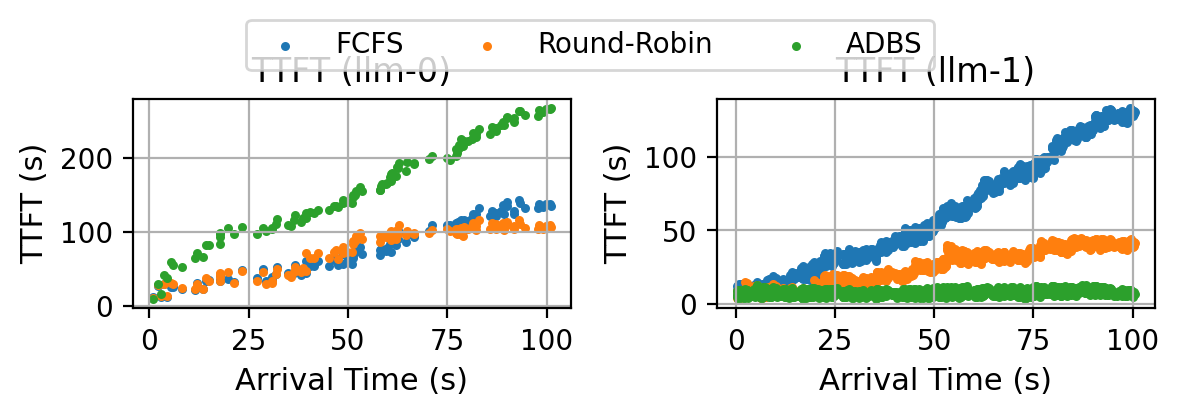

In [8]:
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from transformers import AutoConfig
from dataclasses import dataclass

@dataclass
class Request:
    req_id: int
    model_name: str
    prompt_len: int
    output_len: int
    arrival_time: int
    submit_time: int
    prefill_end: int
    end: int


colors = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#82B0D2"]


def get_time(line):
    time_str = " ".join(line.split(" ")[1:3])
    dtime = datetime.strptime(time_str, "%m-%d %H:%M:%S.%f")
    return dtime


def plot_fairness(logfiles,
                  models,
                  token_block=True,
                  end_time=None,
                  out_fig=None,
                  map_names=None):
    data, dtime = {}, {}
    all_requests = {}
    all_model_names = set()
    rates = {}
    for approach, logfile in logfiles.items():
        data[approach] = {}
        dtime[approach] = []
        all_requests[approach] = []
        with open(logfile, "r") as f:
            find_result = False
            base_time = None
            for line in f.readlines():
                if "MuxScheduler Begin to schedule requests" in line:
                    find_result = True
                    base_time = get_time(line)
                    continue
                if find_result and "[Block Usage]" in line:
                    dtime[approach].append(
                        (get_time(line) - base_time).total_seconds())
                    linestr = line.split("[Block Usage]")[-1]
                    for model in linestr.split(","):
                        if len(model.strip()) == 0:
                            continue
                        model_name = model.split(":")[0].strip()
                        usage = int(model.split(":")[1].strip())
                        if model_name not in data[approach]:
                            data[approach][model_name] = []
                        if token_block:
                            usage = usage / models[model_name]
                        data[approach][model_name].append(usage)
                if "Request" in line:
                    request_info = line.strip().split()
                    req_id = int(request_info[request_info.index("Request") +
                                              1])
                    model_name = request_info[request_info.index("model") + 1]
                    prompt_len = int(
                        request_info[request_info.index("prompt") + 1])
                    output_len = int(
                        request_info[request_info.index("output") + 1])
                    arrival_time = float(
                        request_info[request_info.index("arrival") + 1])
                    submit_time = float(
                        request_info[request_info.index("submit") + 1])
                    prefill_end = float(
                        request_info[request_info.index("prefill_end") + 1])
                    end = float(request_info[request_info.index("end") + 1])
                    req = Request(req_id, model_name, prompt_len, output_len,
                                  arrival_time, submit_time, prefill_end, end)
                    all_requests[approach].append(req)
                    all_model_names.add(model_name)

                if "Model:" in line and "rate:" in line:
                    linestr = line.split()
                    model_name = linestr[linestr.index("Model:") + 1]
                    rate = float(linestr[linestr.index("rate:") + 1])
                    rates[model_name] = rate

    # request statistics
    for approach in all_requests:
        model_req_stats = {}
        for req in all_requests[approach]:
            if req.model_name not in model_req_stats:
                model_req_stats[req.model_name] = []
            model_req_stats[req.model_name].append((req.prompt_len, req.output_len))

        for model in sorted(model_req_stats):
            avg_prompt_len = sum([x[0] for x in model_req_stats[model]]) / len(model_req_stats[model])
            avg_output_len = sum([x[1] for x in model_req_stats[model]]) / len(model_req_stats[model])
            print(f"Model {model} avg prompt len {avg_prompt_len:.2f}, avg output len {avg_output_len:.2f}")
        break

    # find time stamp when the first model is finished
    approach_finished_time = {}
    for approach in dtime:
        finish_time = 1e9
        start_time = 0
        for model in data[approach]:
            for i in range(len(data[approach][model])):
                if data[approach][model][i] > 1:
                    start_time = max(start_time, dtime[approach][i])
                    break

        for model in data[approach]:
            find_running_tick = False
            for i in reversed(range(len(data[approach][model]))):
                if dtime[approach][i] > start_time and data[approach][model][
                        i] < 1:
                    finish_time = min(finish_time, dtime[approach][i])
                    find_running_tick = True
                    continue
                if find_running_tick:
                    break
        # we take 95% of the finish time
        finish_time = finish_time * 0.8
        approach_finished_time[approach] = 130 #finish_time

        # count requests finished for each model
        model_finished_reqs = {}
        for req in all_requests[approach]:
            if req.model_name not in model_finished_reqs:
                model_finished_reqs[req.model_name] = []
            if req.end <= finish_time:
                model_finished_reqs[req.model_name].append(req)
        total_tpt, weighted_tpt = 0, 0
        for model in sorted(model_finished_reqs):
            num_reqs = len(model_finished_reqs[model])
            tpt = num_reqs / finish_time
            total_tpt += tpt
            rates[model] = rates.get(model, 1)
            weighted_tpt += tpt * rates[model]
            print(
                f"Model {model} finished {num_reqs} requests, tpt {tpt:.3f} req/s"
            )
        weighted_tpt = weighted_tpt / sum(rates.values())
        print(f"[{approach}] Total throughput {total_tpt:.3f} req/s, "
              f"Finish time {finish_time:.3f} s, "
              f"Weighted throughput {weighted_tpt:.3f} req/s")

    fig, axs = plt.subplots(1, len(data), figsize=(6, 2), dpi=200)
    for j, approach in enumerate(data):
        ax = axs[j]
        x = dtime[approach]
        approach_datas = []
        model_token_bocks = []
        len_x = len(x)
        if end_time is not None:
            len_x = len([t for t in x if t <= end_time])
        x = x[:len_x]
        for i, model in enumerate(sorted(data[approach])):
            arr = np.array(data[approach][model][:len_x])

            if len(approach_datas) > 0:
                arr += approach_datas[-1][1]
            approach_datas.append((model, arr))
            ax.plot(x, arr, color="black", lw=0.8)

            ax.fill_between(
                x,
                approach_datas[-2][1] if len(approach_datas) > 1 else 0,
                approach_datas[-1][1],
                label=model if map_names is None else map_names[model],
                alpha=1,
                color=colors[i % len(colors)])

            blocks_used = 0
            for k in range(len(arr)):
                if x[k] < approach_finished_time[approach]:
                    blocks_used += arr[k]
            model_token_bocks.append([model, blocks_used])

        # base = model_token_bocks[0][1]
        # for i in reversed(range(len(model_token_bocks))):
        #     if i == 0:
        #         break
        #     model_token_bocks[i][
        #         1] = model_token_bocks[i][1] - model_token_bocks[i - 1][1]
        #     base = min(base, model_token_bocks[i][1])
        # percentage
        base = model_token_bocks[0][1]
        for i in reversed(range(len(model_token_bocks))):
            if i == 0:
                break
            model_token_bocks[i][
                1] = model_token_bocks[i][1] - model_token_bocks[i - 1][1]
            base = base + model_token_bocks[i][1]
        key_str, value_str = "", ""
        for i in range(len(model_token_bocks)):
            key_str += f"{model_token_bocks[i][0]}:"
            value_str += f"{model_token_bocks[i][1] / base * 100:.1f}%:"
        key_str = key_str[:-1]
        value_str = value_str[:-1]

        ax.set_xlabel("Time (s)", fontsize=11)
        ax.grid()
        # ax.set_title(f"Fairness ({approach})\n {key_str} = {value_str}")
        if j == 2:
            ax.text(0.55, 0.35, f"{value_str}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,
                    fontsize=8)
        else:
            ax.text(0.55,
                    0.1,
                    f"{value_str}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,
                    fontsize=8)
        ax.set_title(f"{approach}")
        yticks = ax.get_yticks()[1:-1]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{y / 1e3:.1f}" for y in yticks])

    axs[0].set_ylabel("Token Block Usage (K)", fontsize=11)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles,
               labels,
               loc='upper center',
               ncol=4,
               bbox_to_anchor=(0.5, 1.1))
    fig.tight_layout()
    if out_fig is not None:
        fig.savefig(out_fig, format="pdf", bbox_inches='tight', pad_inches=0.02)
    fig.show()

    # plot TTFT time
    fig, axs = plt.subplots(1, len(all_model_names), figsize=(6, 2), dpi=200)
    all_model_names = sorted(all_model_names)
    for i in range(len(all_model_names)):
        model_name = all_model_names[i]
        ax = axs[i]
        for approach in all_requests:
            x, y = [], []
            for req in all_requests[approach]:
                if req.model_name == model_name:
                    x.append(req.arrival_time)
                    y.append(req.end - req.arrival_time)
            ax.scatter(x, y, label=approach, s=5)
        ax.set_xlabel("Arrival Time (s)", fontsize=11)
        ax.set_ylabel("TTFT (s)", fontsize=11)
        ax.grid()
        ax.set_title(f"TTFT ({model_name})")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles,
               labels,
               loc='upper center',
               ncol=4,
               bbox_to_anchor=(0.5, 1.05))
    fig.tight_layout()
    # fig.savefig(
    #     "/mnt/afs/jfduan/LLMInfer/MuxServe/log/fairness/{}_ttft.pdf".
    #     format(key_words), bbox_inches='tight', pad_inches=0.02)
    fig.show()

logdir = "/mnt/afs/jfduan/LLMInfer/MuxServe/log/fairness"
map_names = None
out_fig = None
end_time = None

# 3x13b, equal rate distribution
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_n3.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_n3_bs256_rate10_fcfs.log",
#     "Round-Robin": f"{logdir}/muxserve_n3_bs256_rate10_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_n3_bs256_rate10_adbs.log",
# }

# 3x13b, different rate distribution
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_n3.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_n3_bs256_rate20_8_2_fcfs.log",
#     "Round-Robin": f"{logdir}/muxserve_n3_bs256_rate20_8_2_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_n3_bs256_rate20_8_2_adbs.log",
# }

# 3x13b, different rate distribution, large BS
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_n3.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_n3_bs1024_rate20_8_2_fcfs.log",
#     "Round-Robin": f"{logdir}/muxserve_n3_bs1024_rate20_8_2_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_n3_bs1024_rate20_8_2_adbs.log",
# }

# 3x13b, equal rate distribution, different seq len
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_n3.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_seqlen_n3_bs256_rate10_fcfs.log",
#     "Round-Robin": f"{logdir}/muxserve_seqlen_n3_bs256_rate10_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_seqlen_n3_bs256_rate10_adbs.log",
# }

# 7b_13b_30b, uneven rate distribution
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_7b_13b_30b.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_7b_13b_30b_bs1024_rate9_10_5_fcfs.log",
#     "Round-Robin":
#     f"{logdir}/muxserve_7b_13b_30b_bs1024_rate9_10_5_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_7b_13b_30b_bs1024_rate9_10_5_adbs.log",
# }

# 7b_13b_30b, uneven rate distribution, small cache
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_7b_13b_30b.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_7b_13b_30b_cache20_bs1024_rate9_10_5_fcfs.log",
#     "Round-Robin":
#     f"{logdir}/muxserve_7b_13b_30b_cache20_bs1024_rate9_10_5_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_7b_13b_30b_cache20_bs1024_rate9_10_5_adbs.log",
# }

# 7b_13b_30b, uneven rate distribution, 30b popular
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_7b_13b_30b.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_7b_13b_30b_bs1024_rate5_9_10_fcfs.log",
#     "Round-Robin":
#     f"{logdir}/muxserve_7b_13b_30b_bs1024_rate5_9_10_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_7b_13b_30b_bs1024_rate5_9_10_adbs.log",
# }

# 7b_13b_30b, uneven rate distribution, 30b popular, small cache
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_7b_13b_30b.yaml"
# logfiles = {
#     "FCFS": f"{logdir}/muxserve_7b_13b_30b_cache20_bs1024_rate5_9_10_fcfs.log",
#     "Round-Robin":
#     f"{logdir}/muxserve_7b_13b_30b_cache20_bs1024_rate5_9_10_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_7b_13b_30b_cache20_bs1024_rate5_9_10_adbs.log",
# }

# 30b_13b_7b, uneven rate distribution, 30b popular
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_30b_13b_7b.yaml"
# prefix = f"muxserve_30b_13b_7b_bs1024_rate4_10_10"
# logfiles = {
#     "FCFS": f"{logdir}/{prefix}_fcfs.log",
#     "Round-Robin": f"{logdir}/{prefix}_roundrobin.log",
#     "ADBS": f"{logdir}/{prefix}_adbs.log",
# }

# >>>>>> one ablation study
model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_65b_30b.yaml"
prefix = f"muxserve_65b_30b_bs1024_rate1_8"
logfiles = {
    "FCFS": f"{logdir}/{prefix}_fcfs.log",
    "Round-Robin": f"{logdir}/{prefix}_roundrobin.log",
    "ADBS": f"{logdir}/{prefix}_adbs_emem.log",
}
end_time=75
map_names = {"llm-0": "LLaMA-65B", "llm-1": "LLaMA-30B"}
out_fig = "/mnt/afs/jfduan/LLMInfer/MuxServe/log/fairness/figs/difflen_65b1_30b8.pdf"

# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_30b_13b_7b_skv.yaml"
# prefix = f"muxserve_30b_13b_7b_p768_g256_cache25_bs512_rate8_4_4"
# logfiles = {
#     "FCFS": f"{logdir}/{prefix}_fcfs.log",
#     "Round-Robin": f"{logdir}/{prefix}_roundrobin.log",
#     "ADBS": f"{logdir}/{prefix}_adbs.log",
# }

# >>>>>> one ablation study: 30b_13b_3b, uneven seqlen (1024:512:512), equal rate distribution
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_30b_13b_7b.yaml"
# prefix = f"muxserve_30b_13b_7b_difflen_cache20_bs512_rate2_8_8"
# logfiles = {
#     "FCFS": f"{logdir}/{prefix}_fcfs.log",
#     "Round-Robin": f"{logdir}/{prefix}_roundrobin.log",
#     "ADBS": f"{logdir}/{prefix}_adbs_emem.log",
# }
# end_time = 100
# map_names = {"llm-0": "LLaMA-30B", "llm-1": "LLaMA-13B", "llm-2": "LLaMA-7B"}
# out_fig = "/mnt/afs/jfduan/LLMInfer/MuxServe/log/fairness/figs/difflen_30b2_13b8_7b8.pdf"

# 2x7b,2x13b, equal rate distribution
# model_config = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/fairness/fairness_n4.yaml"
# logfiles = {
#     "Round-Robin": f"{logdir}/muxserve_n4_bs512_rate8_roundrobin.log",
#     "ADBS": f"{logdir}/muxserve_n4_bs512_rate8_adbs.log",
# }

with open(model_config, "r") as f:
    config = yaml.safe_load(f)
models = {}
for job_config in config["models"]:
    name = job_config["name"]
    model = job_config["model"]
    model_config = AutoConfig.from_pretrained(model)
    tp_size = job_config["tensor_parallel_size"]

    num_heads = model_config.num_attention_heads // tp_size
    num_layers = model_config.num_hidden_layers
    models[name] = num_heads * num_layers

    print(f"Model {name} ({model}) group size {models[name]} blocks")

plot_fairness(logfiles,
              models,
              token_block=True,
              end_time=end_time,
              out_fig=out_fig,
              map_names=map_names)